# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


## ⚙️ Import Libraries

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision

import pandas as pd
import random
from sklearn.model_selection import train_test_split

# Set seed for TensorFlow
seed = 42
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

np.random.seed(seed)
tf.random.set_seed(seed);

2.17.0


## ⏳ Load the Data

In [63]:
data = np.load('training_set.npz')
X = data['images'] # Array of 13759 images (96x96x3 each)
y = data['labels'] # Array of 13759 labels (numbers from 0 to 7)

X = X[:11959]
y = y[:11959]

TEST_SIZE = round(X.shape[0] / 10) # 10%
VAL_SIZE = round(X.shape[0] / 10) # 10%

# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=seed,
    stratify=y
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=VAL_SIZE,
    random_state=seed,
    stratify=y_train_val
)

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

from sklearn.utils.class_weight import compute_class_weight
y_cw = np.squeeze(y_train)

classes = np.unique(y_cw)
class_weights = compute_class_weight('balanced', classes=classes, y=y_cw)
# Convert to dictionary
#class_weights = class_weights * class_weights
#class_weights = [max(val, 1) for val in class_weights]

class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights: "+str(class_weight_dict))

# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))
y_test = tfk.utils.to_categorical(y_test, num_classes=len(class_names))

# Print the shapes of the resulting sets
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
print('Test set shape:\t\t', X_test.shape, y_test.shape)


Class Weights: {0: 1.753482404692082, 1: 0.6853151862464183, 2: 1.379325259515571, 3: 0.7381944444444445, 4: 1.7612297496318114, 5: 1.504245283018868, 6: 0.6415638412017167, 7: 0.9094106463878328}
Training set shape:	 (9567, 96, 96, 3) (9567, 8)
Validation set shape:	 (1196, 96, 96, 3) (1196, 8)
Test set shape:		 (1196, 96, 96, 3) (1196, 8)


Initialise MobileNetV3Small model with pretrained weights, for transfer learning

In [67]:
def build_model():
  # Initialise MobileNetV3Small model with pretrained weights, for transfer learning
  mobilenet = tfk.applications.ResNet50V2(
      input_shape=(96, 96, 3),
      include_top=False,
      weights='imagenet',
      pooling='avg'
  )

  # Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
  mobilenet.trainable = False

  # Define input layer with shape matching the input images
  inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

  # Define a sequential model for image augmentation with various transformations
  augmentation = tf.keras.Sequential([
      tfkl.RandomContrast(0.7),
      tfkl.RandomFlip("horizontal_and_vertical"),
      tfkl.RandomTranslation(0.2,0.2),
      tfkl.RandomRotation(0.2),
      tfkl.RandomZoom(0.2),
  ], name='preprocessing')

  x = augmentation(inputs, training=True)
  x = tfkl.BatchNormalization()(x)

  # Pass augmented inputs through the MobileNetV3Small feature extractor
  x = mobilenet(x)

  # Add a dropout layer for regularisation
  x = tfkl.Dropout(0.3, name='dropout')(x)

  # Add final Dense layer for classification with softmax activation
  outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

  # Define the complete model linking input and output
  tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with categorical cross-entropy loss and Adam optimiser
  tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adadelta(), metrics=['accuracy'])


  # Display a summary of the model architecture
  #mobilenet.summary(expand_nested=True)

  return tl_model


## 🛠️ Train and Save the Model

In [68]:
# Add your implementation here
model = build_model()
model.summary(expand_nested=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast_16              │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_16 (RandomFlip)     │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_16           │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_16              │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_16 (RandomZoom)     │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 96, 96, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_32 (InputLayer)     │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv1_pad (ZeroPadding2D)       │ (None, 102, 102, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv1_conv (Conv2D)             │ (None, 48, 48, 64)          │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ pool1_pad (ZeroPadding2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ pool1_pool (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_preact_bn          │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_preact_relu        │ (None, 24, 24, 64)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_1_conv (Conv2D)    │ (None, 24, 24, 64)          │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_1_bn               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 23,581,204 (89.96 MB)

 Trainable params: 16,398 (64.05 KB)

 Non-trainable params: 23,564,806 (89.89 MB)

In [ ]:
# Add your implementation here
model = build_model()

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 1000,
    validation_data = (X_val, y_val),
    class_weight = class_weight_dict,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=7, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.1571 - loss: 5.6249 - val_accuracy: 0.1957 - val_loss: 3.7108
Epoch 2/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.1590 - loss: 5.4052 - val_accuracy: 0.1145 - val_loss: 5.1794
Epoch 3/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.1635 - loss: 5.2635 - val_accuracy: 0.1254 - val_loss: 4.7530
Epoch 4/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.1660 - loss: 5.0762 - val_accuracy: 0.1329 - val_loss: 4.3757
Epoch 5/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.1577 - loss: 4.9123 - val_accuracy: 0.1405 - val_loss: 4.2249
Epoch 6/1000
124/150 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.1613 - loss: 4.7579

In [33]:
model.save('weights.keras')
del model

In [22]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('weights.keras')

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_1            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_1 (RandomZoom)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 96, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv1_pad (ZeroPadding2D)       │ (None, 102, 102, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv1_conv (Conv2D)             │ (None, 48, 48, 64)          │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ pool1_pad (ZeroPadding2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ pool1_pool (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_preact_bn          │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_preact_relu        │ (None, 24, 24, 64)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_1_conv (Conv2D)    │ (None, 24, 24, 64)          │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_1_bn               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 23,614,002 (90.08 MB)

 Trainable params: 16,398 (64.05 KB)

 Non-trainable params: 23,564,806 (89.89 MB)

 Optimizer params: 32,798 (128.12 KB)

In [23]:
# Set the MobileNetV3Small model layers as trainable
ft_model.get_layer('resnet50v2').trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer('resnet50v2').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 conv1_conv Conv2D True
7 conv2_block1_1_conv Conv2D True
11 conv2_block1_2_conv Conv2D True
14 conv2_block1_0_conv Conv2D True
15 conv2_block1_3_conv Conv2D True
19 conv2_block2_1_conv Conv2D True
23 conv2_block2_2_conv Conv2D True
26 conv2_block2_3_conv Conv2D True
30 conv2_block3_1_conv Conv2D True
34 conv2_block3_2_conv Conv2D True
38 conv2_block3_3_conv Conv2D True
42 conv3_block1_1_conv Conv2D True
46 conv3_block1_2_conv Conv2D True
49 conv3_block1_0_conv Conv2D True
50 conv3_block1_3_conv Conv2D True
54 conv3_block2_1_conv Conv2D True
58 conv3_block2_2_conv Conv2D True
61 conv3_block2_3_conv Conv2D True
65 conv3_block3_1_conv Conv2D True
69 conv3_block3_2_conv Conv2D True
72 conv3_block3_3_conv Conv2D True
76 conv3_block4_1_conv Conv2D True
80 conv3_block4_2_conv Conv2D True
84 conv3_block4_3_conv Conv2D True
88 conv4_block1_1_conv Conv2D True
92 conv4_block1_2_conv Conv2D True
95 conv4_block1_0_conv Conv2D True
96 conv4_block1_3_conv Conv2D True
100 conv4_block2_1_conv Conv2D 

In [24]:
# Set the number of layers to freeze
N = 170

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('resnet50v2').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(ft_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

0 input_layer_2 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_contrast_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomContrast)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_1            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_1 (RandomZoom)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 96, 96, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv1_pad (ZeroPadding2D)       │ (None, 102, 102, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv1_conv (Conv2D)             │ (None, 48, 48, 64)          │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ pool1_pad (ZeroPadding2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ pool1_pool (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_preact_bn          │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_preact_relu        │ (None, 24, 24, 64)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_1_conv (Conv2D)    │ (None, 24, 24, 64)          │           4,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ conv2_block1_1_bn               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 23,614,002 (90.08 MB)

 Trainable params: 7,884,814 (30.08 MB)

 Non-trainable params: 15,696,390 (59.88 MB)

 Optimizer params: 32,798 (128.12 KB)

In [25]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adadelta(), metrics=['accuracy'])

In [26]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 1000,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'blood_cells'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 124ms/step - accuracy: 0.8477 - loss: 0.4577 - val_accuracy: 0.8487 - val_loss: 0.4270
Epoch 2/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.8656 - loss: 0.4108 - val_accuracy: 0.8445 - val_loss: 0.4482
Epoch 3/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.8619 - loss: 0.4015 - val_accuracy: 0.8562 - val_loss: 0.4202
Epoch 4/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.8635 - loss: 0.3909 - val_accuracy: 0.8620 - val_loss: 0.4141
Epoch 5/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.8691 - loss: 0.3837 - val_accuracy: 0.8579 - val_loss: 0.4068
Epoch 6/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.8696 - loss: 0.3905 - val_accuracy: 0.8579 - val_loss: 0.4069
Epoch 7/1000
150/150 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.8653 - loss: 0.3877 - val_accuracy: 0.8478 - val_loss: 0.4250
Final validation accuracy: 86.2%


In [34]:
class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [35]:
# Predict labels for the entire test set
model = Model()

predictions = model.predict(X_test)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step
Predictions Shape: (1196,)


[6 6 0 ... 7 7 6]
Accuracy score over the test set: 0.8579
Precision score over the test set: 0.8812
Recall score over the test set: 0.8579
F1 score over the test set: 0.8581


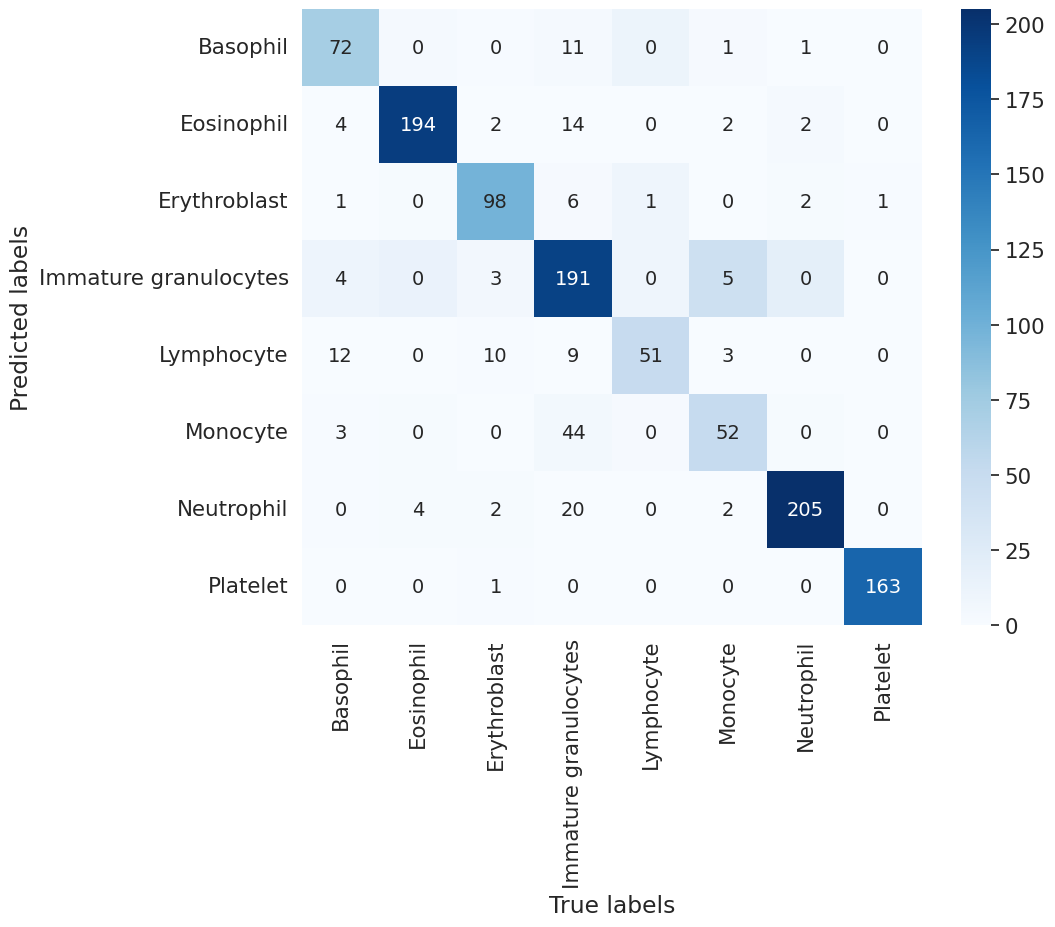

In [36]:
# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)
print(true_classes)
# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, predictions)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, predictions, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, predictions, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, predictions, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predictions)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_names), yticklabels=list(class_names), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 18%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>